In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 9.9MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 16.5MB/s 


In [2]:
!wget https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1 -O erm.zip

--2021-03-03 18:37:53--  https://www.dropbox.com/s/qrdswgzv63o3opg/datasetCorregido.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/qrdswgzv63o3opg/datasetCorregido.zip [following]
--2021-03-03 18:37:54--  https://www.dropbox.com/s/dl/qrdswgzv63o3opg/datasetCorregido.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7b55034c4ae65a7fef4c62eed5.dl.dropboxusercontent.com/cd/0/get/BJ-S4DRNvpTfGkLo53GPh0HnVf5CaZjc06_Xia7f_Nj43ZKwVkz9qpAEwSmrlgPx3h997VJlHkJqXZOxuAULOHhFNRURZN_PqOmMclpI73rcDym6t8g1A_59OWttAukrjoU/file?dl=1# [following]
--2021-03-03 18:37:54--  https://uc7b55034c4ae65a7fef4c62eed5.dl.dropboxusercontent.com/cd/0/get/BJ-S4DRNvpTfGkLo53GPh0HnVf5CaZjc06_Xia7f_Nj43ZKwVkz9qpAEwSmrlgPx3h997VJlHkJqXZOxuAULO

In [3]:
!unzip erm.zip

Archive:  erm.zip
   creating: datasetCorregido/
   creating: datasetCorregido/train/
   creating: datasetCorregido/train/no/
  inflating: datasetCorregido/train/no/anonymized_482127.jpg  
  inflating: datasetCorregido/train/no/anonymized_174749.jpg  
  inflating: datasetCorregido/train/no/anonymized_734047.jpg  
  inflating: datasetCorregido/train/no/anonymized_581767.jpg  
  inflating: datasetCorregido/train/no/anonymized_1400777.jpg  
  inflating: datasetCorregido/train/no/anonymized_347431.jpg  
  inflating: datasetCorregido/train/no/anonymized_626433.jpg  
  inflating: datasetCorregido/train/no/anonymized_1372303.jpg  
  inflating: datasetCorregido/train/no/anonymized_1324599.jpg  
  inflating: datasetCorregido/train/no/anonymized_196853.jpg  
  inflating: datasetCorregido/train/no/anonymized_687000.jpg  
  inflating: datasetCorregido/train/no/anonymized_504041.jpg  
  inflating: datasetCorregido/train/no/anonymized_1414333.jpg  
  inflating: datasetCorregido/train/no/anonymized_3

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('datasetCorregido/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=True,flip_vert=True,
                      max_rotate=360,max_warp=0,max_zoom=1.1,
                      max_lighting=0.1,p_lighting=0.5), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=32)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18')
]

In [9]:
modelo='resnest50d_4s2x40d'

## Ranger

In [10]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [11]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-resnest/resnest50_fast_4s2x40d-41d14ed0.pth" to /root/.cache/torch/hub/checkpoints/resnest50_fast_4s2x40d-41d14ed0.pth


SuggestedLRs(lr_min=2.511886486900039e-06, lr_steep=6.309573450380412e-07)

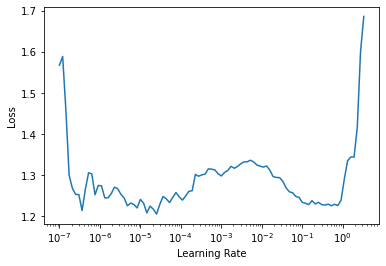

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.259948,0.957669,0.515290,0.501377,0.572327,00:57
1,1.214298,0.866071,0.529052,0.513736,0.588050,00:56


Better model found at epoch 0 with valid_loss value: 0.9576687812805176.


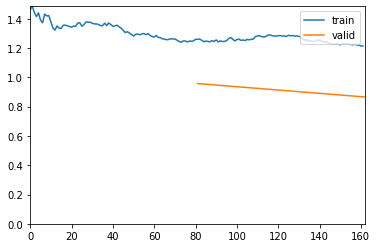

Better model found at epoch 1 with valid_loss value: 0.866070568561554.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.240407,0.849522,0.533639,0.518625,0.569182,01:13
1,1.202704,0.830763,0.548930,0.533923,0.569182,01:12
2,1.174752,0.819548,0.553517,0.541935,0.528302,01:12
3,1.164451,0.786873,0.562691,0.543716,0.625786,01:12
4,1.129291,0.778575,0.574924,0.553476,0.650943,01:12
5,1.117414,0.761967,0.577982,0.557377,0.641509,01:12
6,1.113935,0.743955,0.574924,0.560606,0.581761,01:12
7,1.059926,0.739458,0.585627,0.570149,0.600629,01:12
8,1.025117,0.718716,0.600917,0.586626,0.606918,01:12
9,1.017759,0.722311,0.599388,0.580000,0.638365,01:12


Better model found at epoch 0 with valid_loss value: 0.8495219349861145.


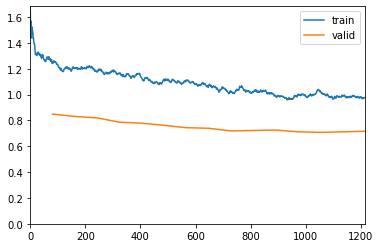

Better model found at epoch 1 with valid_loss value: 0.8307633399963379.
Better model found at epoch 2 with valid_loss value: 0.8195483684539795.
Better model found at epoch 3 with valid_loss value: 0.7868731021881104.
Better model found at epoch 4 with valid_loss value: 0.7785754799842834.
Better model found at epoch 5 with valid_loss value: 0.7619667649269104.
Better model found at epoch 6 with valid_loss value: 0.7439553141593933.
Better model found at epoch 7 with valid_loss value: 0.7394576072692871.
Better model found at epoch 8 with valid_loss value: 0.7187159061431885.
Better model found at epoch 11 with valid_loss value: 0.7121482491493225.
Better model found at epoch 12 with valid_loss value: 0.7077674269676208.


In [13]:
learn.fine_tune(15,freeze_epochs=2)

In [14]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

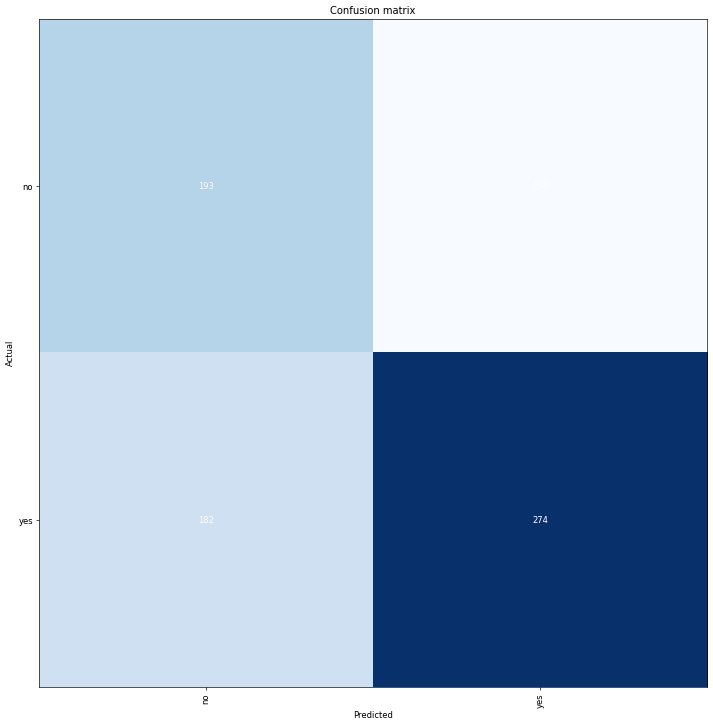

In [15]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [16]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5786864757537842.


(#4) [0.7535858750343323,0.5786864757537842,0.6342592592592593,0.6008771929824561]

## Faltten

In [17]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.275509,1.022626,0.582569,0.548387,0.801887,00:56
1,0.958458,0.702345,0.614679,0.576389,0.783019,00:56


Better model found at epoch 0 with valid_loss value: 1.0226263999938965.


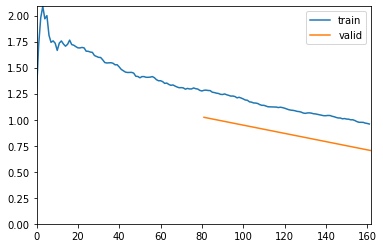

Better model found at epoch 1 with valid_loss value: 0.7023451328277588.


In [18]:
learn.fit_flat_cos(2,lr=1e-3)

In [19]:
learn.unfreeze()

SuggestedLRs(lr_min=2.0892961401841602e-06, lr_steep=0.0002290867705596611)

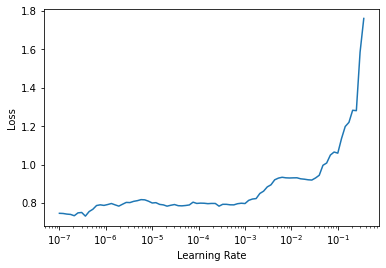

In [20]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.991004,18.760504,0.515290,0.503067,0.257862,01:11
1,1.053777,4.909421,0.478593,0.478821,0.817610,01:11
2,1.128838,1.774692,0.490826,0.427184,0.138365,01:11
3,1.083952,0.764147,0.507645,0.250000,0.006289,01:10
4,1.015147,1.129395,0.492355,0.487037,0.827044,01:10
5,1.009789,1.125381,0.501529,0.394737,0.047170,01:10
6,1.021126,1.593363,0.524465,0.640000,0.050314,01:10


Better model found at epoch 0 with valid_loss value: 18.7605037689209.


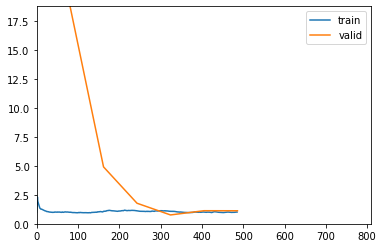

Better model found at epoch 1 with valid_loss value: 4.909420967102051.
Better model found at epoch 2 with valid_loss value: 1.774692177772522.
Better model found at epoch 3 with valid_loss value: 0.764147162437439.
No improvement since epoch 3: early stopping


In [21]:
learn.fit_flat_cos(10,lr=1e-2)

In [22]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

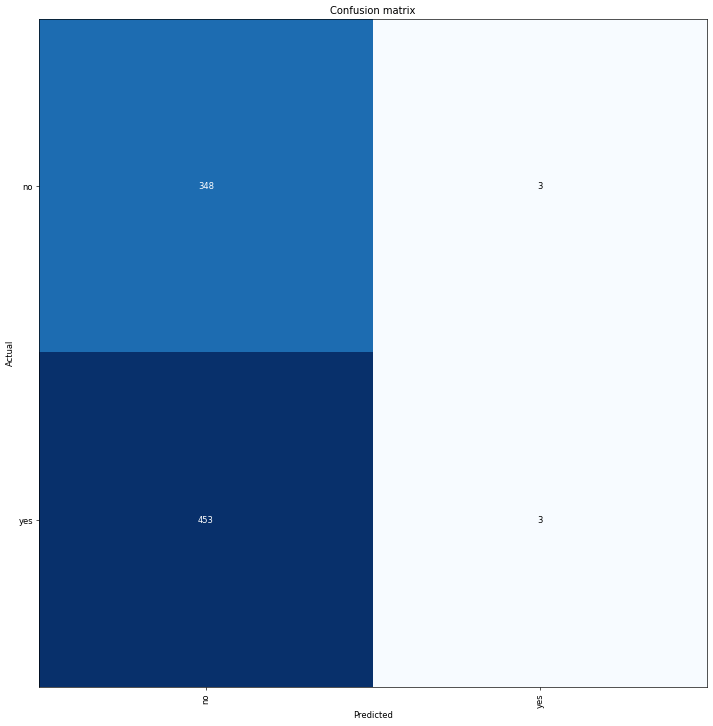

In [23]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [24]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.4349442422389984.


(#4) [0.8034997582435608,0.4349442422389984,0.5,0.006578947368421052]

## LabelSmoothing

In [25]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

SuggestedLRs(lr_min=9.120108734350651e-06, lr_steep=4.365158383734524e-05)

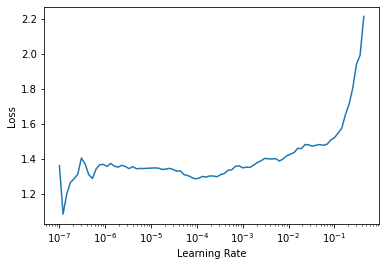

In [26]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.248379,1.109502,0.591743,0.590747,0.522013,00:56
1,1.077145,0.820209,0.573394,0.563518,0.544025,00:56


Better model found at epoch 0 with valid_loss value: 1.1095020771026611.


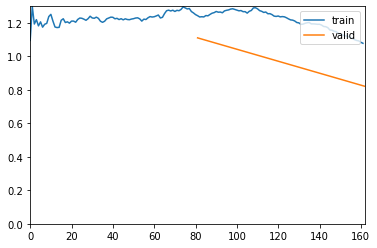

Better model found at epoch 1 with valid_loss value: 0.8202085494995117.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.816839,0.692816,0.593272,0.591549,0.528302,01:11
1,0.740886,0.671908,0.625382,0.618893,0.597484,01:11
2,0.714398,0.642236,0.643731,0.612137,0.729560,01:11
3,0.681838,0.664187,0.643731,0.651246,0.575472,01:11
4,0.660762,0.633879,0.672783,0.708000,0.556604,01:11
5,0.645481,0.637422,0.660550,0.620603,0.776730,01:11
6,0.632950,0.630940,0.657492,0.657718,0.616352,01:11
7,0.611387,0.612963,0.674312,0.665615,0.663522,01:11
8,0.600085,0.607570,0.704893,0.706271,0.672956,01:11
9,0.588115,0.596627,0.700306,0.711806,0.644654,01:11


Better model found at epoch 0 with valid_loss value: 0.6928163766860962.


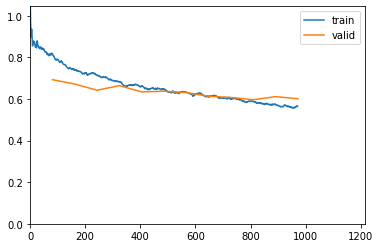

Better model found at epoch 1 with valid_loss value: 0.6719076037406921.
Better model found at epoch 2 with valid_loss value: 0.6422358155250549.
Better model found at epoch 4 with valid_loss value: 0.6338791847229004.
Better model found at epoch 6 with valid_loss value: 0.6309399604797363.
Better model found at epoch 7 with valid_loss value: 0.6129629611968994.
Better model found at epoch 8 with valid_loss value: 0.6075699925422668.
Better model found at epoch 9 with valid_loss value: 0.5966272950172424.
No improvement since epoch 9: early stopping


In [27]:
learn.fine_tune(15,freeze_epochs=2)

In [28]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

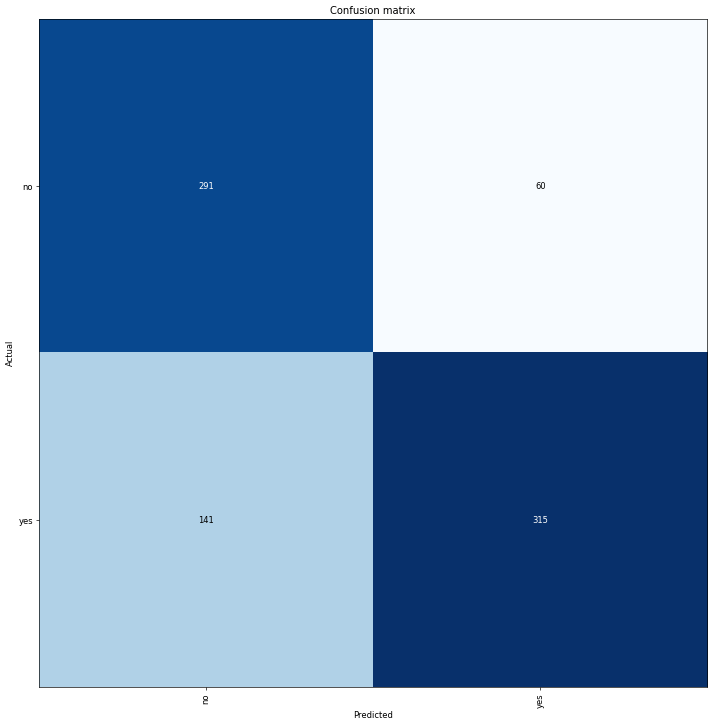

In [29]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [30]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7509293556213379.


(#4) [0.5536822080612183,0.7509293556213379,0.84,0.6907894736842105]

## MixUp

In [31]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [32]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.243674,1.178749,0.538226,0.517316,0.751572,00:56
1,1.068432,0.729944,0.565749,0.545699,0.638365,00:56


Better model found at epoch 0 with valid_loss value: 1.178748607635498.


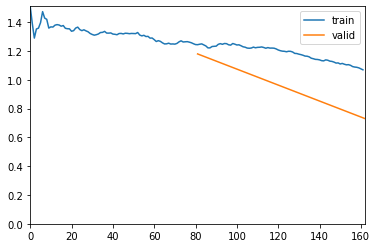

Better model found at epoch 1 with valid_loss value: 0.7299442887306213.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.804065,0.676702,0.608563,0.610714,0.537736,01:12
1,0.773563,0.678724,0.577982,0.550000,0.726415,01:12
2,0.735704,0.669305,0.591743,0.572238,0.635220,01:12
3,0.696825,0.631329,0.651376,0.632353,0.676101,01:11
4,0.674766,0.626362,0.631498,0.640000,0.553459,01:12
5,0.673492,0.609640,0.680428,0.684746,0.635220,01:11
6,0.655538,0.604655,0.668196,0.637602,0.735849,01:11
7,0.645090,0.648608,0.640673,0.593258,0.830189,01:11
8,0.622696,0.616331,0.666667,0.612108,0.858491,01:12
9,0.616803,0.576425,0.704893,0.706271,0.672956,01:11


Better model found at epoch 0 with valid_loss value: 0.6767022609710693.


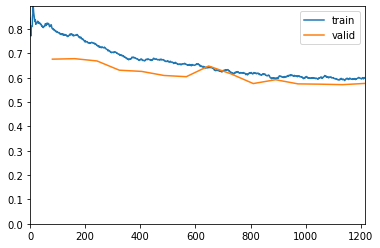

Better model found at epoch 2 with valid_loss value: 0.6693047285079956.
Better model found at epoch 3 with valid_loss value: 0.6313294172286987.
Better model found at epoch 4 with valid_loss value: 0.6263619661331177.
Better model found at epoch 5 with valid_loss value: 0.6096400022506714.
Better model found at epoch 6 with valid_loss value: 0.6046549081802368.
Better model found at epoch 9 with valid_loss value: 0.5764247179031372.
Better model found at epoch 11 with valid_loss value: 0.5751215815544128.
Better model found at epoch 12 with valid_loss value: 0.5738901495933533.
Better model found at epoch 13 with valid_loss value: 0.5719283223152161.


In [33]:
learn.fine_tune(15,freeze_epochs=2)

In [34]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

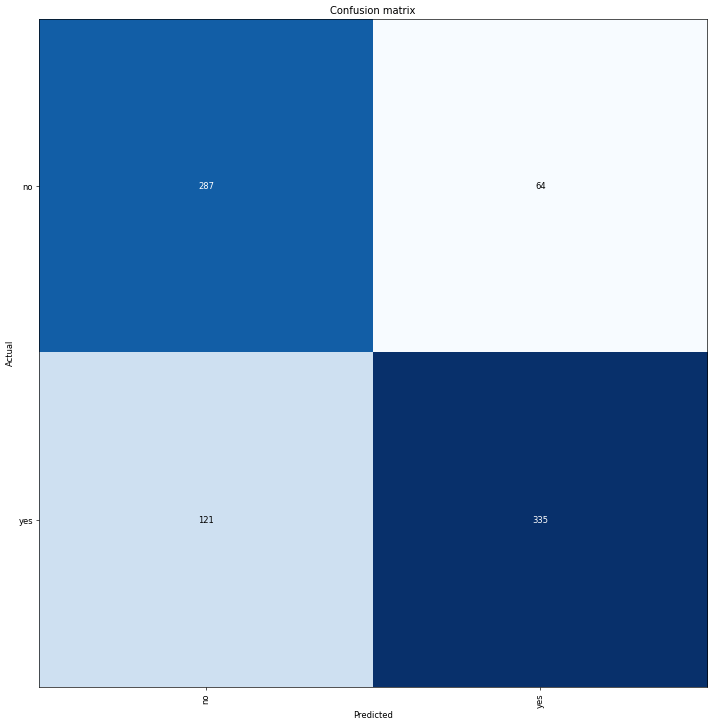

In [35]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [36]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7707558870315552.


(#4) [0.5070605278015137,0.7707558870315552,0.8395989974937343,0.7346491228070176]

## Ranger + Flat cosin Anneal

In [37]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.270725,0.928757,0.496942,0.479853,0.411950,00:56
1,1.257513,0.913993,0.503058,0.488372,0.462264,00:56


Better model found at epoch 0 with valid_loss value: 0.9287571310997009.


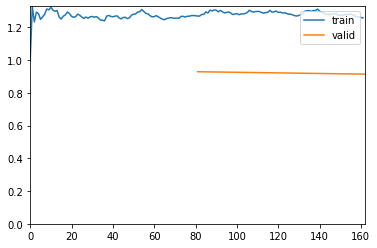

Better model found at epoch 1 with valid_loss value: 0.9139931797981262.


In [38]:
learn.fit_flat_cos(2,lr=1e-3)

In [39]:
learn.unfreeze()

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=1.9054607491852948e-06)

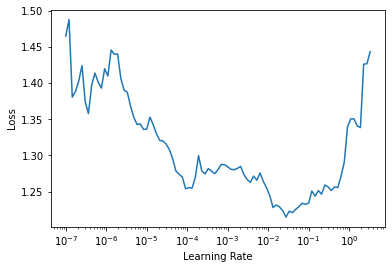

In [40]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.230348,0.765227,0.579511,0.564565,0.591195,01:12
1,1.087553,0.753304,0.553517,0.535326,0.619497,01:12
2,0.980475,0.758547,0.519878,0.507407,0.430818,01:12
3,0.844007,0.692594,0.529052,0.514881,0.544025,01:12
4,0.766994,0.668970,0.597859,0.618026,0.452830,01:12
5,0.709398,0.650145,0.620795,0.708333,0.374214,01:12
6,0.676324,0.617410,0.651376,0.714286,0.471698,01:12
7,0.658123,0.616207,0.646789,0.639871,0.625786,01:12
8,0.649475,0.599362,0.674312,0.699620,0.578616,01:12
9,0.607308,0.598777,0.688073,0.745690,0.544025,01:12


Better model found at epoch 0 with valid_loss value: 0.7652269601821899.


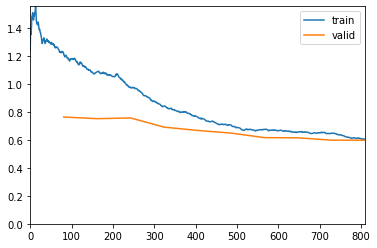

Better model found at epoch 1 with valid_loss value: 0.7533040642738342.
Better model found at epoch 3 with valid_loss value: 0.692593514919281.
Better model found at epoch 4 with valid_loss value: 0.6689699292182922.
Better model found at epoch 5 with valid_loss value: 0.6501448750495911.
Better model found at epoch 6 with valid_loss value: 0.6174100637435913.
Better model found at epoch 7 with valid_loss value: 0.6162070035934448.
Better model found at epoch 8 with valid_loss value: 0.5993616580963135.
Better model found at epoch 9 with valid_loss value: 0.5987769365310669.


In [41]:
learn.fit_flat_cos(10,lr=1e-2)

In [42]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [43]:
learn.dls = dlsTest

In [44]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6703841090202332.


(#4) [0.5994933247566223,0.6703841090202332,0.8104575163398693,0.543859649122807]

## Ranger+Flar Cossin Anneal+LabelSmoothing

In [45]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.231024,0.903094,0.501529,0.487342,0.484277,00:56
1,1.211872,0.891788,0.518349,0.505190,0.459119,00:56


Better model found at epoch 0 with valid_loss value: 0.903094470500946.


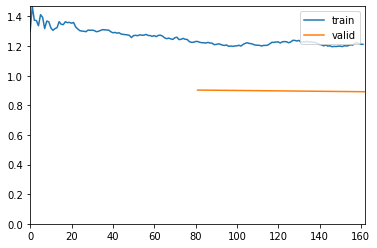

Better model found at epoch 1 with valid_loss value: 0.8917876482009888.


In [46]:
learn.fit_flat_cos(2,lr=1e-3)

In [47]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=1.0964781722577754e-06)

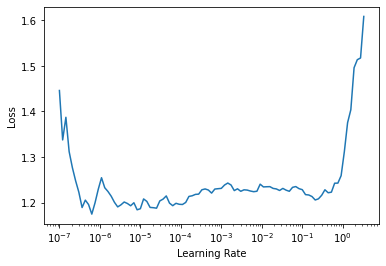

In [48]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.170945,0.813527,0.541284,0.532143,0.468553,01:12
1,1.057867,0.825425,0.521407,0.509434,0.424528,01:12
2,0.950267,0.724688,0.541284,0.532374,0.465409,01:12
3,0.852019,0.717499,0.527523,0.509165,0.786164,01:12
4,0.778557,0.734362,0.533639,0.515081,0.698113,01:12
5,0.747923,0.710250,0.529052,0.511312,0.710692,01:12
6,0.707425,0.686221,0.574924,0.569930,0.512579,01:12
7,0.689849,0.680318,0.553517,0.538235,0.575472,01:12
8,0.679358,0.680426,0.570336,0.555556,0.581761,01:12
9,0.675094,0.664893,0.596330,0.596429,0.525157,01:12


Better model found at epoch 0 with valid_loss value: 0.8135271668434143.


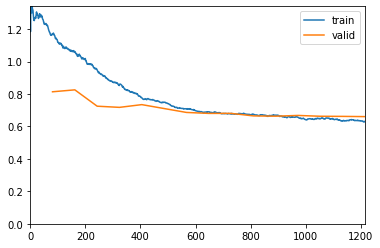

Better model found at epoch 2 with valid_loss value: 0.7246883511543274.
Better model found at epoch 3 with valid_loss value: 0.7174994945526123.
Better model found at epoch 5 with valid_loss value: 0.7102504968643188.
Better model found at epoch 6 with valid_loss value: 0.6862205266952515.
Better model found at epoch 7 with valid_loss value: 0.6803175806999207.
Better model found at epoch 9 with valid_loss value: 0.6648929119110107.
Better model found at epoch 10 with valid_loss value: 0.6630653142929077.
Better model found at epoch 12 with valid_loss value: 0.6626582741737366.
Better model found at epoch 13 with valid_loss value: 0.6618803143501282.
Better model found at epoch 14 with valid_loss value: 0.6604993939399719.


In [49]:
learn.fit_flat_cos(15,lr=1e-2)

In [50]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [51]:
learn.dls = dlsTest

In [52]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6356877088546753.


(#4) [0.6494044065475464,0.6356877088546753,0.7237569060773481,0.5745614035087719]

## Ranger +Flat + Label + MixUp

In [53]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.283439,0.862429,0.558104,0.552347,0.481132,00:56
1,1.271980,0.844903,0.544343,0.532258,0.518868,00:56


Better model found at epoch 0 with valid_loss value: 0.8624285459518433.


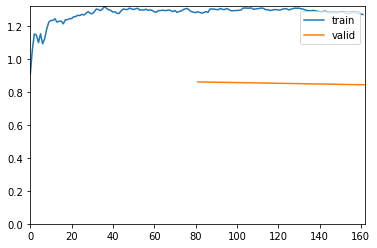

Better model found at epoch 1 with valid_loss value: 0.8449028730392456.


In [54]:
learn.fit_flat_cos(2,lr=1e-3)

In [55]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.156701,0.824393,0.496942,0.482428,0.474843,01:12
1,1.025376,0.706765,0.599388,0.593333,0.559748,01:12
2,0.934702,0.738664,0.574924,0.616279,0.333333,01:12
3,0.835461,0.683244,0.590214,0.586806,0.531447,01:12
4,0.773896,0.682840,0.590214,0.635870,0.367925,01:12
5,0.734209,0.680586,0.599388,0.659091,0.364780,01:12
6,0.710431,0.668405,0.600917,0.652406,0.383648,01:12
7,0.691800,0.664111,0.602446,0.639423,0.418239,01:12
8,0.684830,0.660494,0.634557,0.736527,0.386792,01:12
9,0.673559,0.645576,0.636086,0.652672,0.537736,01:12


Better model found at epoch 0 with valid_loss value: 0.8243927359580994.


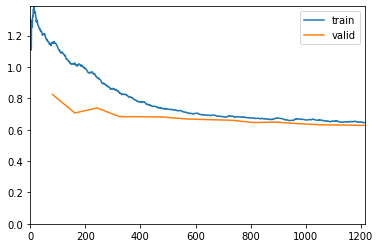

Better model found at epoch 1 with valid_loss value: 0.7067646980285645.
Better model found at epoch 3 with valid_loss value: 0.6832438707351685.
Better model found at epoch 4 with valid_loss value: 0.6828402876853943.
Better model found at epoch 5 with valid_loss value: 0.680586040019989.
Better model found at epoch 6 with valid_loss value: 0.6684051752090454.
Better model found at epoch 7 with valid_loss value: 0.6641112565994263.
Better model found at epoch 8 with valid_loss value: 0.6604935526847839.
Better model found at epoch 9 with valid_loss value: 0.6455762386322021.
Better model found at epoch 11 with valid_loss value: 0.6386920809745789.
Better model found at epoch 12 with valid_loss value: 0.6308729648590088.
Better model found at epoch 13 with valid_loss value: 0.629653811454773.
Better model found at epoch 14 with valid_loss value: 0.6274692416191101.


In [56]:
learn.fit_flat_cos(15,lr=1e-2)

In [57]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

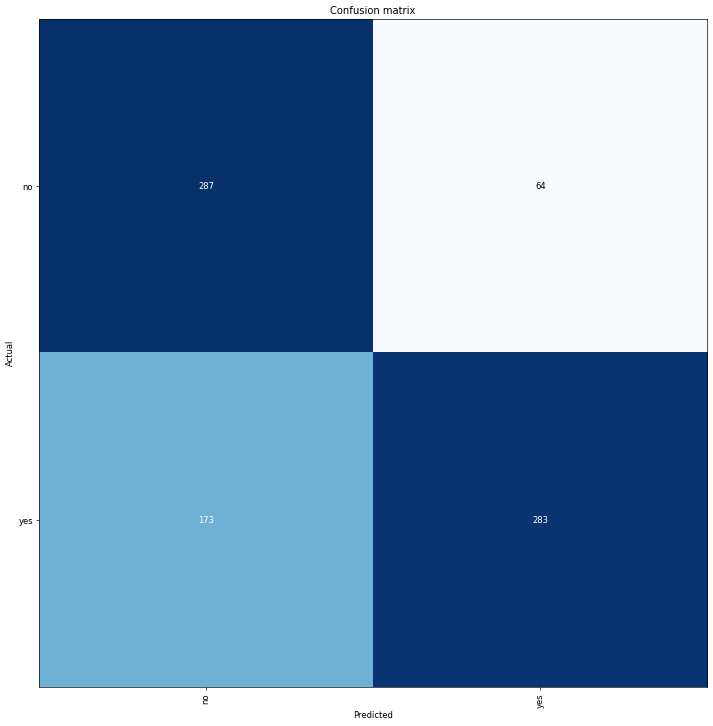

In [58]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [59]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7063196897506714.


(#4) [0.6012404561042786,0.7063196897506714,0.8155619596541787,0.6206140350877193]

## Ranger + Flat + MixUp

In [60]:
mixup=MixUp()
callbacks2 = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnest18'),
    mixup
]

In [61]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.322433,0.945869,0.493884,0.479624,0.481132,00:56
1,1.285586,0.918251,0.498471,0.485465,0.525157,00:56


Better model found at epoch 0 with valid_loss value: 0.945868730545044.


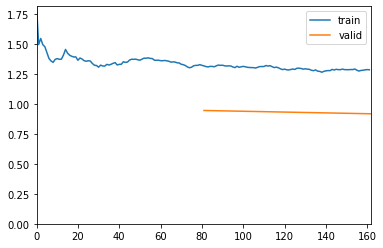

Better model found at epoch 1 with valid_loss value: 0.9182506203651428.


In [62]:
learn.fit_flat_cos(2,lr=1e-3)

In [63]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.222041,0.877214,0.525994,0.518349,0.355346,01:12
1,1.095131,0.812385,0.525994,0.516000,0.405660,01:12
2,1.009489,0.766910,0.513761,0.500000,0.625786,01:12
3,0.898127,0.710502,0.553517,0.565000,0.355346,01:12
4,0.805012,0.696080,0.542813,0.528190,0.559748,01:12
5,0.737232,0.691460,0.574924,0.576336,0.474843,01:12
6,0.708756,0.668872,0.576453,0.574007,0.500000,01:12
7,0.692177,0.656062,0.591743,0.598456,0.487421,01:12
8,0.673670,0.645053,0.648318,0.634969,0.650943,01:12
9,0.674389,0.641718,0.648318,0.691304,0.500000,01:12


Better model found at epoch 0 with valid_loss value: 0.8772135972976685.


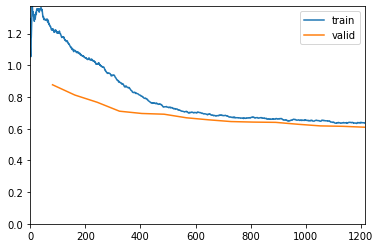

Better model found at epoch 1 with valid_loss value: 0.812384843826294.
Better model found at epoch 2 with valid_loss value: 0.766909658908844.
Better model found at epoch 3 with valid_loss value: 0.7105017304420471.
Better model found at epoch 4 with valid_loss value: 0.6960800886154175.
Better model found at epoch 5 with valid_loss value: 0.6914600133895874.
Better model found at epoch 6 with valid_loss value: 0.6688718795776367.
Better model found at epoch 7 with valid_loss value: 0.6560623049736023.
Better model found at epoch 8 with valid_loss value: 0.6450533270835876.
Better model found at epoch 9 with valid_loss value: 0.6417177319526672.
Better model found at epoch 10 with valid_loss value: 0.6400306224822998.
Better model found at epoch 11 with valid_loss value: 0.6279972791671753.
Better model found at epoch 12 with valid_loss value: 0.6177093386650085.
Better model found at epoch 13 with valid_loss value: 0.6151366829872131.
Better model found at epoch 14 with valid_loss va

In [64]:
learn.fit_flat_cos(15,lr=1e-2)

In [65]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [66]:
learn.dls = dlsTest

In [67]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6827757358551025.


(#4) [0.5930371880531311,0.6827757358551025,0.7645502645502645,0.6337719298245614]

## Ranger + MixUp

In [68]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [69]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.338827,1.150245,0.490826,0.485089,0.767296,00:57
1,1.321663,1.027601,0.516820,0.502041,0.773585,00:57


Better model found at epoch 0 with valid_loss value: 1.1502454280853271.


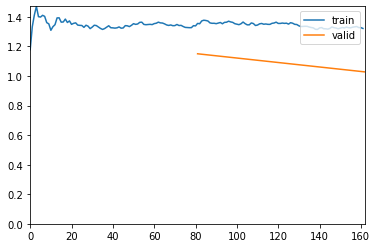

Better model found at epoch 1 with valid_loss value: 1.027600884437561.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.239702,1.044460,0.509174,0.497110,0.811321,01:12
1,1.242674,0.977573,0.512232,0.498986,0.773585,01:12
2,1.202879,0.967643,0.513761,0.500000,0.776730,01:12
3,1.203181,0.925941,0.516820,0.502058,0.767296,01:12
4,1.207082,0.879783,0.536697,0.516199,0.751572,01:12
5,1.152873,0.843170,0.548930,0.526682,0.713836,01:12
6,1.146050,0.887926,0.527523,0.509202,0.783019,01:12
7,1.112885,0.849934,0.530581,0.511727,0.754717,01:12
8,1.116163,0.831453,0.542813,0.520607,0.754717,01:12
9,1.085467,0.825003,0.545872,0.522581,0.764151,01:12


Better model found at epoch 0 with valid_loss value: 1.0444600582122803.


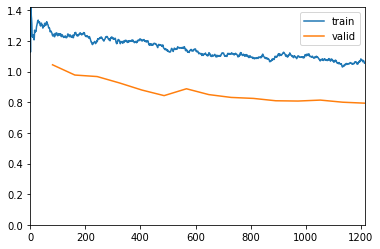

Better model found at epoch 1 with valid_loss value: 0.9775729179382324.
Better model found at epoch 2 with valid_loss value: 0.967643141746521.
Better model found at epoch 3 with valid_loss value: 0.9259409308433533.
Better model found at epoch 4 with valid_loss value: 0.8797831535339355.
Better model found at epoch 5 with valid_loss value: 0.8431698679924011.
Better model found at epoch 8 with valid_loss value: 0.8314527273178101.
Better model found at epoch 9 with valid_loss value: 0.8250027894973755.
Better model found at epoch 10 with valid_loss value: 0.8096657991409302.
Better model found at epoch 11 with valid_loss value: 0.8077945709228516.
Better model found at epoch 13 with valid_loss value: 0.8002222180366516.
Better model found at epoch 14 with valid_loss value: 0.7938653230667114.


In [70]:
learn.fine_tune(15,freeze_epochs=2)

In [71]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [72]:
learn.dls = dlsTest

In [73]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5910780429840088.


(#4) [0.7405620813369751,0.5910780429840088,0.614963503649635,0.7390350877192983]

## Faltten + MixUp

In [74]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()])

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.304146,0.832674,0.573394,0.550649,0.666667,00:56
1,0.992938,0.687711,0.599388,0.585366,0.603774,00:56


Better model found at epoch 0 with valid_loss value: 0.8326743841171265.


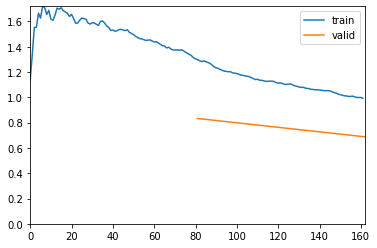

Better model found at epoch 1 with valid_loss value: 0.6877113580703735.


In [75]:
learn.fit_flat_cos(2,lr=1e-3)

In [76]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.972753,0.918008,0.486239,0.485342,0.937107,01:10
1,1.016077,19.624714,0.506116,0.483444,0.229560,01:10
2,1.223206,1.959206,0.486239,0.486239,1.000000,01:10
3,1.097025,0.700407,0.513761,0.000000,0.000000,01:10
4,0.988518,2.554392,0.484709,0.446927,0.251572,01:10
5,1.038378,0.761593,0.486239,0.486196,0.996855,01:10
6,0.995074,1.027487,0.510703,0.400000,0.012579,01:10


Better model found at epoch 0 with valid_loss value: 0.9180082082748413.


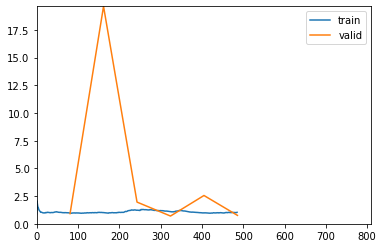

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 3 with valid_loss value: 0.700406551361084.
No improvement since epoch 3: early stopping


In [77]:
learn.fit_flat_cos(10,lr=1e-2)

In [78]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [79]:
learn.dls = dlsTest

In [80]:
learn.validate()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 0 with valid_loss value: 0.4349442422389984.


(#4) [0.7242836356163025,0.4349442422389984,0.0,0.0]

## Ranger + Label

In [81]:
opt_func = partial(ranger, beta=(0.9,0.99), eps=1e-6)

In [82]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],opt_func=opt_func,loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.249019,1.026541,0.501529,0.491667,0.742138,00:56
1,1.213190,0.916023,0.500000,0.489703,0.672956,00:56


Better model found at epoch 0 with valid_loss value: 1.0265406370162964.


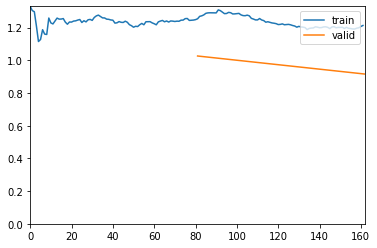

Better model found at epoch 1 with valid_loss value: 0.9160225987434387.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.159372,0.882020,0.498471,0.486772,0.578616,01:12
1,1.200727,0.907528,0.513761,0.500000,0.707547,01:12
2,1.168444,0.865188,0.515290,0.501319,0.597484,01:12
3,1.139921,0.865482,0.529052,0.511416,0.704403,01:12
4,1.118268,0.843099,0.512232,0.498708,0.606918,01:12
5,1.089767,0.812836,0.541284,0.524457,0.606918,01:12
6,1.076381,0.804077,0.550459,0.530612,0.654088,01:12
7,1.043770,0.788728,0.562691,0.542553,0.641509,01:12
8,1.032693,0.777309,0.548930,0.530831,0.622642,01:12
9,1.030243,0.779020,0.553517,0.532338,0.672956,01:12


Better model found at epoch 0 with valid_loss value: 0.8820199966430664.


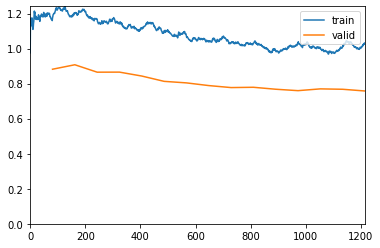

Better model found at epoch 2 with valid_loss value: 0.8651876449584961.
Better model found at epoch 4 with valid_loss value: 0.843098521232605.
Better model found at epoch 5 with valid_loss value: 0.8128358125686646.
Better model found at epoch 6 with valid_loss value: 0.8040770292282104.
Better model found at epoch 7 with valid_loss value: 0.7887282967567444.
Better model found at epoch 8 with valid_loss value: 0.7773087620735168.
Better model found at epoch 10 with valid_loss value: 0.7678399682044983.
Better model found at epoch 11 with valid_loss value: 0.7597541809082031.
Better model found at epoch 14 with valid_loss value: 0.7578246593475342.


In [83]:
learn.fine_tune(15,freeze_epochs=2)

In [84]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [85]:
learn.dls = dlsTest

In [86]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.6059479713439941.


(#4) [0.726088285446167,0.6059479713439941,0.6487068965517241,0.6600877192982456]

## Faltten + Label

In [87]:
learn = timm_learner(dls512, modelo,cbs = callbacks,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.301648,0.971253,0.565749,0.592391,0.342767,00:56
1,1.001956,0.744519,0.610092,0.614545,0.531447,00:56


Better model found at epoch 0 with valid_loss value: 0.9712527990341187.


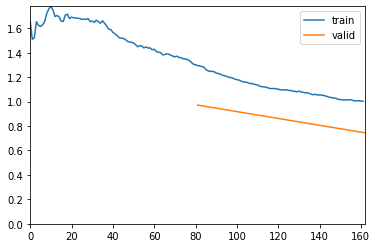

Better model found at epoch 1 with valid_loss value: 0.7445185780525208.


In [88]:
learn.fit_flat_cos(2,lr=1e-3)

In [89]:
learn.unfreeze()

SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=6.918309736647643e-06)

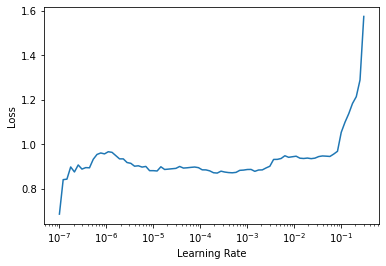

In [90]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.070156,1.264354,0.490826,0.488000,0.959119,01:11
1,1.023494,16.503983,0.484709,0.485179,0.977987,01:11
2,1.050344,3.729169,0.513761,0.000000,0.000000,01:10
3,1.025336,0.735386,0.490826,0.488038,0.962264,01:10
4,1.019237,16.364573,0.493884,0.489149,0.921384,01:10
5,1.038256,0.703622,0.495413,0.490654,0.990566,01:10
6,0.998205,0.785417,0.486239,0.486239,1.000000,01:10
7,0.990432,0.728625,0.486239,0.486239,1.000000,01:10
8,0.998191,0.968750,0.510703,0.000000,0.000000,01:10


Better model found at epoch 0 with valid_loss value: 1.26435387134552.


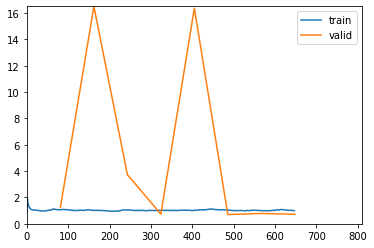

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Better model found at epoch 3 with valid_loss value: 0.7353859543800354.
Better model found at epoch 5 with valid_loss value: 0.7036217451095581.
No improvement since epoch 5: early stopping


In [91]:
learn.fit_flat_cos(10,lr=1e-2)

In [92]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [93]:
learn.dls = dlsTest

In [94]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.5675340890884399.


(#4) [0.6933984756469727,0.5675340890884399,0.5669586983729662,0.993421052631579]

## Label + MixUp

In [95]:
learn = timm_learner(dls512, modelo,cbs = callbacks2,metrics=[accuracy,Precision(),Recall()],loss_func=LabelSmoothingCrossEntropy())

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,1.315196,1.069834,0.548930,0.548117,0.411950,00:56
1,1.101029,0.746668,0.556575,0.540698,0.584906,00:56


Better model found at epoch 0 with valid_loss value: 1.0698338747024536.


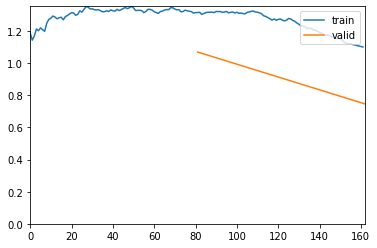

Better model found at epoch 1 with valid_loss value: 0.7466682195663452.


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.807011,0.677182,0.607034,0.622490,0.487421,01:12
1,0.786415,0.676497,0.573394,0.548148,0.698113,01:12
2,0.747310,0.674674,0.591743,0.562347,0.723270,01:12
3,0.716190,0.654627,0.642202,0.690909,0.477987,01:12
4,0.691861,0.644441,0.636086,0.625000,0.628931,01:12
5,0.664146,0.612529,0.688073,0.715909,0.594340,01:12
6,0.662458,0.613403,0.697248,0.717391,0.622642,01:12
7,0.655796,0.615726,0.681957,0.713178,0.578616,01:12
8,0.646786,0.622876,0.681957,0.643979,0.773585,01:12


Better model found at epoch 0 with valid_loss value: 0.6771821975708008.


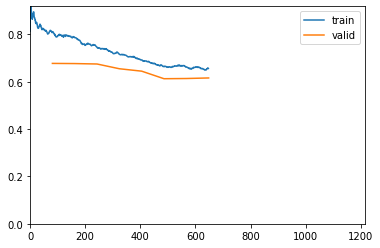

Better model found at epoch 1 with valid_loss value: 0.676497220993042.
Better model found at epoch 2 with valid_loss value: 0.6746739149093628.
Better model found at epoch 3 with valid_loss value: 0.6546270847320557.
Better model found at epoch 4 with valid_loss value: 0.6444408893585205.
Better model found at epoch 5 with valid_loss value: 0.6125285029411316.
No improvement since epoch 5: early stopping


In [96]:
learn.fine_tune(15,freeze_epochs=2)

In [97]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

In [98]:
learn.dls = dlsTest

In [99]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7001239061355591.


(#4) [0.5931358337402344,0.7001239061355591,0.8074712643678161,0.6162280701754386]